## REINFORCE algorithm
----------------------------------------------------------------------------------------------------
Three key features of any RL algorithm:
1. Policy: $\pi_\theta$ = Probablities of all actions, given a state. Parameterized by $\theta$.  
2. Objective function: $ \max_\limits{\theta} J(\pi_{\theta}) = \mathop{\mathbb{E}}_{\tau \sim \pi_\theta} [R(\tau)]$
3. Method: Way to udate the parameters = Policy Gradient

Policy gradient numerical computation
- Plain vanilla: $\nabla_\theta J(\pi_\theta)  = \mathbb{E}_{\tau \sim \pi_\theta} \; [ \; \sum_{t=0}^T R_t(\tau) \; \nabla_\theta \ln \pi_\theta(a_t \vert s_t) \;]$
- With Monte Carlo sampling and approximation: $\nabla_\theta J(\pi_\theta) \approx [ \; \sum_{t=0}^T R_t(\tau) \; \nabla_\theta \ln \pi_\theta(a_t \vert s_t) \;]$

- With baseline: $\nabla_\theta J(\theta) \approx [ \; \sum_{t=0}^T (R_t(\tau) - b(s_t)) \; \nabla_\theta \ln \pi_\theta(a_t \vert s_t) \;]$
- Where, baseline does not change per time-step, it is for the entire trajectory
- One baseline option: $V^\pi$ - leads to Actor-Critic algorithm
- Simpler option: Average returns over trajectory: $b = \frac{1}{T}\sum_{t=0}^T R_t(\tau) $

### Algorithm
1. Initialize $\alpha$, $\gamma$ and $\theta$ i.e. weigths of the NN
2. for episodes = 0 to MAX_EPISODES:
    - sample trajectory $\tau$
    - set $\nabla_\theta J(\pi_{\theta})$ = 0
    - for t=0 to T:
        - $R_t(\tau) = \sum_{t'=t}^{T} \gamma^{t'-t} r'_t$
        - $\nabla_\theta J(\pi_\theta)  = \mathbb{E}_{\tau \sim \pi_\theta} \; [ \; \sum_{t=0}^T R_t(\tau) \; \nabla_\theta \ln \pi_\theta(a_t \vert s_t) \;]$
    - end for sampled trajectory
    - $\theta = \theta + \alpha \nabla_\theta J(\pi_\theta) $
3. end for all episodes 

### Implementation notes:
1. Code is inspired by Laura Graesser's _(LG, 2020 book)_ implementation, however with large modifications
2. We use the concept of Agent (instead of 'pi' or 'policy_pi') and a separate network class (i.e. how the function approximator is implemented, it could well be a linear regression)
3. **Important concept**: "Loss" in the implementation below, is the "objective" $J$. In our algorithm, we want to **maximize** it. PyTorch's optimizer, by default, MINIMIZES it (as it is called "loss"), we therefore add "-" negate it, so as to maximize it. 
4. Also in the final plot, notice "loss" is RISING and follows the rewards, which is expected as "loss" is really being maximized.  
5. self.pd.probs = prob. distribution of all actions
6. Sum of all possible action probabilities = 1.0
7. Note that episodes > 300 start showing repeated patterns. Rewards drop and rise in cylces. 300 is ideal and hence suggested in LG (2020)

In [72]:
import gym
import numpy as np
import torch

from torch.distributions import Categorical
import torch.nn as nn
import torch.optim as optim

from utilities import plot_learning_curve 

In [73]:
gamma = 0.99
alpha = 0.01
EPISODES = 300

### Network class - function approximator
- Simple one layer MLP

In [74]:
class PolicyNetwork(nn.Module):
    
    # Step 1: Define the network architecture
    def __init__(self, lr, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        
        # 1.1. Define network architecture
        layers = [
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
        ]
        
        # 1.3. Assemble the network and this becomes our "model" i.e function approximation (i.e. "model") 
        self.model = nn.Sequential(*layers)
        
        # 1.2. Adam optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
    # Step 2: Feed-forward algo. PyTorch handles back-prop for us, but feed-forward we must provide
    def feed_forward(self, state):
        # Probability distribution (pd) parameters
        pdparam = self.model(state)
        return (pdparam)

### Agent class
- This will also "hold" the policy network, defined above, by class PolicyNetwork
- Other agent specific activities:
    - Learn the "policy" using the "policy network" above
    - Decide what action to take
    - On-policy type - so discard previous experiences 

In [75]:
class Agent():
    def __init__(self, input_dim, n_actions, alpha, gamma):
        self.input_dim = input_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.alpha = alpha
        
        self.log_probs = []
        self.rewards = []
        self.pd = None
        # Create the policy network
        self.policy_network = PolicyNetwork(self.alpha, self.input_dim, self.n_actions)
                
        # On-policy, so discard previous experiences. Empty buffer
        self.onpolicy_reset()
        
        # Call training loop
        # self.learn()
        
    def onpolicy_reset(self):
        self.log_probs = []
        self.rewards = []
        
    def act(self, state):
        x = torch.from_numpy(state.astype(np.float32)) # Convert to tensor
        pdparam = self.policy_network.feed_forward(x) # forward pass
        pd = Categorical(logits=pdparam) # probability distribution
        ## Note: 
        # 1. self.pd.probs = prob. distribution of all actions
        # 2. Sum of all possible action probabilities = 1.0
        action = pd.sample() # pi(a|s) in action via pd
        log_prob = pd.log_prob(action) # log prob of pi(a|s)
        self.log_probs.append(log_prob) # store for training
        return (action.item())
    
    def learn(self):
        # Inner gradient-ascent loop
        T = len(self.rewards) # Length of a trajectory
        returns = np.empty(T, dtype=np.float32)
        future_returns = 0.0

        # Compute returns
        for t in reversed(range(T)):
            future_returns = self.rewards[t] + gamma*future_returns
            returns[t] = future_returns

        returns = torch.tensor(returns)
        log_probs = torch.stack(self.log_probs)
        
        loss = torch.sum(- log_probs*returns) # Compute gradient term. Negative for maximizing
        self.policy_network.optimizer.zero_grad()
        loss.backward() # backpropogate and compute gradients
        self.policy_network.optimizer.step() # gradient ascent, update the weights
        return (loss)

### Main loop

[000] Loss:     221.78 | Total reward:    26.00 | Solved: False
[010] Loss:     156.38 | Total reward:    21.00 | Solved: False
[020] Loss:     796.04 | Total reward:    53.00 | Solved: False
[030] Loss:     431.80 | Total reward:    40.00 | Solved: False
[040] Loss:    2467.54 | Total reward:   107.00 | Solved: False
[050] Loss:     849.70 | Total reward:    57.00 | Solved: False
[060] Loss:    3244.30 | Total reward:   135.00 | Solved: False
[070] Loss:     202.43 | Total reward:    28.00 | Solved: False
[080] Loss:     271.36 | Total reward:    34.00 | Solved: False
[090] Loss:     109.52 | Total reward:    22.00 | Solved: False
[100] Loss:     297.71 | Total reward:    34.00 | Solved: False
[110] Loss:      87.84 | Total reward:    18.00 | Solved: False
[120] Loss:     339.52 | Total reward:    34.00 | Solved: False
[130] Loss:     512.84 | Total reward:    50.00 | Solved: False
[140] Loss:    4786.15 | Total reward:   185.00 | Solved: False
[150] Loss:    3916.56 | Total reward:  

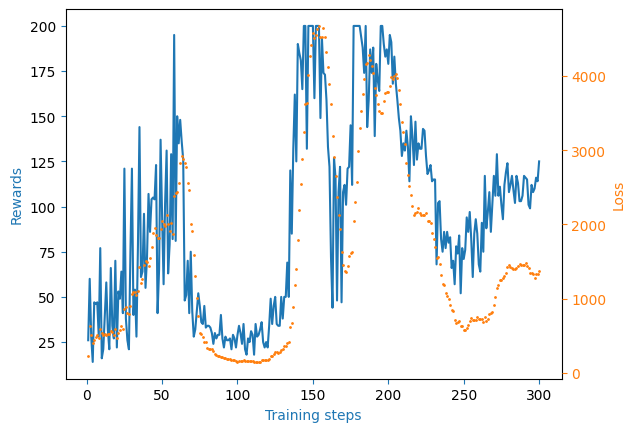

In [76]:
rewards_history = []
loss_history = []

env = gym.make('CartPole-v0')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

agent = Agent(input_dim, output_dim, alpha, gamma)

for episode in range(EPISODES):
    state = env.reset()
    
    # Sample a trajectory. 
    for t in range(200): # Max. time-steps for CartPole is 200
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        agent.rewards.append(reward)
        #env.render()
        if done:
            break
        
    loss = agent.learn() # train per episode
    total_reward = sum(agent.rewards)
    
    rewards_history.append(total_reward)
    loss_history.append(loss.item()) # Extract values from list of torch items for plotting
    
    solved = total_reward > 195.0
    agent.onpolicy_reset()

    if (episode%10 ==0):
        print(f'[{episode:03d}] Loss: {loss:>10.2f} | Total reward: {total_reward:>8.2f} | Solved: {solved}')

env.close()

x = [i+1 for i in range(EPISODES)]
plot_learning_curve(x, rewards_history=rewards_history, loss_history=loss_history, 
                    moving_avg_n=10, filename='CartPole_REINFORCE.png') 